In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

In [147]:
def static(r1,m1,r2,m2,theta):
    return(r2 * math.cos(theta)*m2*g - r1*math.cos(theta)*m1*g)


def static2(r1,m1,r2,m2,theta):
    return(r2 * math.sin(theta)*m1*g)


In [156]:
#Constants:
g= 9.81 #m/s^2
Al_Den = 2.7 #g/cm^3
r1 = 0.5 #m - Winch side
m1 = 0.5 #kg - Winch side

r2 = 1.5 #m - Intake side (variable)
m2 = 8 #kg - Intake side



In [198]:
#-------Inputs
start = 0 #radians
end = (1) * math.pi #radians
armStart = 1
armEnd = 1.5

armAdjust = True

def ArmDataCalc(start,end,armStart,armEnd, armAdjust=True):
    #-------Function Code
    startVel = 0
    startAccel = 0
    curArmVel = 0
    curArmAccel = 0
    curArm = armStart
    curVel = startVel
    curAccel = startAccel
    theta = start
    maxRotVel = 2 #radians/sec
    maxRotAcc = 5 #radians/sec^2
    maxArmVel = 3 #m/s
    maxArmAcc = 10 # m/s^2

    ArmData = []
    #----Rotational Calculations-----

    AccelTime = maxRotVel/maxRotAcc
    duration = (abs(start-end))/maxRotVel + 2 * AccelTime
    DecellTime = duration - AccelTime
    curTor = static(curArm,m1,r2,m2,start)

    if armAdjust:
        #----Length Calculations-----
        ##Distance covered during acceleration phase
        ArmAccelTime = maxArmVel/maxArmAcc
        AccDist = (ArmAccelTime**2) * maxArmAcc
        #Calculate the total time to retract at steady velocity
        if armStart > AccDist:
            ArmRetractTime = (armStart - 2*AccDist)/maxArmVel + 2 * ArmAccelTime
            #Time to start slowing the retraction
            ArmRetractStop = ArmRetractTime
        else:
            ArmRetractTime = 2 * math.sqrt(armStart/maxArmAcc)
            #Time to start slowing the retraction
            ArmRetractStop = ArmRetractTime/2
        
        #Calculate total time required for extension
        ArmExtensionTime = (armEnd - AccDist)/ maxArmVel
        ##Back calcuate stop time so that end length is acheived when the arm finishes its rotation.
        ArmExtensionStop = duration - ArmAccelTime
        ArmExtensionStart = ArmExtensionStop - ArmExtensionTime - ArmAccelTime
        print("ArmAccelTime",ArmAccelTime)
        print("ArmRetractTime",ArmRetractTime)
        print("ArmRetractStop",ArmRetractStop)
        print("ArmExtensionTime",ArmExtensionTime)
        print("ArmExtensionStop",ArmExtensionStop)
        print("ArmExtensionStart",ArmExtensionStart)
        print("Duration", duration)
    else:
        armDist  = armEnd - armStart
        ArmAccelTime = maxArmVel/maxArmAcc
        AccDist = (ArmAccelTime**2) * maxArmAcc
        if abs(armDist) > AccDist:
            ArmRetractTime = (abs(armDist) - 2*AccDist)/maxArmVel + 2 * ArmAccelTime
            #Time to start slowing the retraction
            ArmRetractStop = ArmRetractTime
        else:
            ArmRetractTime = 2 * math.sqrt(abs(armDist)/maxArmAcc)
            #Time to start slowing the retraction
            ArmRetractStop = ArmRetractTime/2

    for time in np.arange(0,duration,0.02):
        #Setting the target angular acceleration and rotational velocity
        if time < AccelTime:
            curVel = curVel + maxAcc * 0.02
            curAccel = maxAcc
        elif time > AccelTime and time < DecellTime:
            curVel = maxRotVel
            curAccel = 0
        elif time > DecellTime:
            curVel = curVel - maxRotAcc * 0.02
            curAccel = -1 * maxRotAcc
        elif time > duration:
            curVel = 0
            curAccel = 0
        theta = theta + curVel * 0.02
        if armAdjust:
            #Setting the Arm Length acceleration and velocity
            if time < ArmAccelTime:
                curArmVel = curArmVel - maxArmAcc * 0.02
                curArmAcc = -1* maxArmAcc
            elif time > ArmAccelTime and time < ArmRetractStop:
                curArmVel = -1 * maxArmVel
                curArmAcc = 0
            elif time > ArmRetractStop and time < ArmRetractStop + ArmAccelTime:
                curArmVel = curArmVel + maxArmAcc * 0.02
                curArmAcc = maxArmAcc
            elif time > ArmRetractStop and time < ArmExtensionStart:
                curArmVel = 0
                curArmAcc = 0
            elif time > ArmExtensionStart and time < ArmExtensionStart + ArmAccelTime:
                curArmVel = curArmVel + maxArmAcc * 0.02
                curArmAcc = maxArmAcc
            elif time > ArmExtensionStart + ArmAccelTime and time < ArmExtensionStop:
                curArmVel = maxArmVel
                curArmAcc = 0
            elif time > ArmExtensionStop and time < duration:
                curArmVel = curArmVel - maxArmAcc * 0.02
                curArmAcc = -1* maxArmAcc
            elif time > duration:
                curArmVel = 0
                curArmAcc = 0
            curArm = curArm + curArmVel * 0.02

        StaticTor = static(curArm,m1,r2,m2,theta)
        I = ArmInteria(curArm)
        InertialTorque = I * curAccel
        TotalTorque = StaticTor + InertialTorque
        ArmData.append([time,curVel,theta, StaticTor,InertialTorque,TotalTorque,curArm, curArmVel])
    if not armAdjust:
        if armDist > 0:
            armFactor = 1
        else: 
            armFactor = -1
        curVel = 0
        curAccel = 0
        for armTime in np.arange(0,ArmRetractTime,0.02):
            if armTime < ArmAccelTime:
                curArmVel = curArmVel + armFactor * maxArmAcc * 0.02
                curArmAcc = armFactor * maxArmAcc
            elif armTime > ArmAccelTime and armTime < ArmRetractStop:
                curArmVel = armFactor * maxArmVel
                curArmAcc = 0
            elif armTime > ArmRetractStop and armTime < ArmRetractStop + ArmAccelTime:
                curArmVel = curArmVel - armFactor * maxArmAcc * 0.02
                curArmAcc = maxArmAcc
            curArm = curArm + curArmVel * 0.02
            StaticTor = static(curArm,m1,r2,m2,theta)
            I = ArmInteria(curArm)
            InertialTorque = I * curAccel
            TotalTorque = StaticTor + InertialTorque
            ArmData.append([time + armTime,curVel,theta, StaticTor,InertialTorque,TotalTorque,curArm, curArmVel])
        
    ArmData = pd.DataFrame(ArmData, columns=['Time','Velocity','Dist','Static','Inertial','Total',
                                             'Arm Length','Arm Velocity'])
    ArmData['Degree'] = 360/(2*math.pi)*ArmData['Dist']
    return(ArmData)

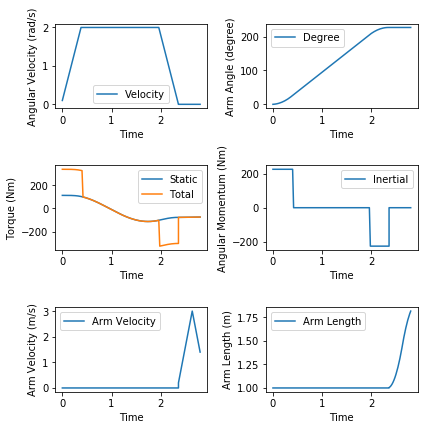

In [199]:
ArmData = ArmDataCalc(start,end,armStart,armEnd, armAdjust=False)
    
fig, axs = plt.subplots(3,2, figsize=(6,6))
ArmData.plot('Time','Velocity', ax=axs[0,0])
axs[0,0].set_ylabel("Angular Velocity (rad/s)")
ArmData.plot('Time','Degree', ax=axs[0,1])
axs[0,1].set_ylabel("Arm Angle (degree)")
ArmData.plot('Time','Static', ax=axs[1,0])
axs[1,0].set_ylabel("Torque (Nm)")
ArmData.plot('Time','Total', ax=axs[1,0])
ArmData.plot('Time','Inertial', ax=axs[1,1])
axs[1,1].set_ylabel("Angular Momentum (Nm)")
ArmData.plot('Time','Arm Length', ax=axs[2,1])
axs[2,1].set_ylabel("Arm Length (m)")
ArmData.plot('Time','Arm Velocity', ax=axs[2,0])
axs[2,0].set_ylabel("Arm Velocity (m/s)")
fig.tight_layout()
plt.show()

ArmAccelTime 0.3
ArmRetractTime 0.33333333333333337
ArmRetractStop 0.33333333333333337
ArmExtensionTime 0.20000000000000004
ArmExtensionStop 2.0707963267948966
ArmExtensionStart 1.5707963267948966
Duration 2.3707963267948964


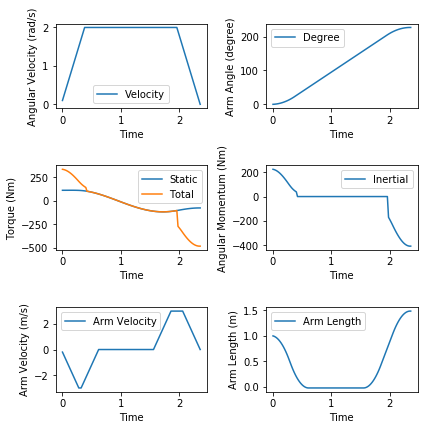

In [187]:
ArmData = ArmDataCalc(start,end,armStart,armEnd, armAdjust=True)
    
fig, axs = plt.subplots(3,2, figsize=(6,6))
ArmData.plot('Time','Velocity', ax=axs[0,0])
axs[0,0].set_ylabel("Angular Velocity (rad/s)")
ArmData.plot('Time','Degree', ax=axs[0,1])
axs[0,1].set_ylabel("Arm Angle (degree)")
ArmData.plot('Time','Static', ax=axs[1,0])
axs[1,0].set_ylabel("Torque (Nm)")
ArmData.plot('Time','Total', ax=axs[1,0])
ArmData.plot('Time','Inertial', ax=axs[1,1])
axs[1,1].set_ylabel("Angular Momentum (Nm)")
ArmData.plot('Time','Arm Length', ax=axs[2,1])
axs[2,1].set_ylabel("Arm Length (m)")
ArmData.plot('Time','Arm Velocity', ax=axs[2,0])
axs[2,0].set_ylabel("Arm Velocity (m/s)")
fig.tight_layout()
plt.show()

In [151]:
#Calculating length dependent Moment of Inertia of extending arm

AvgArmCx = 2.57 #cm^2

Al_den = 2.7 #g/cm^3

def armMass(r):
    #Returns arm mass in g when given an arm length (r)
    #Uses an avearge crossectional area of 2.57 in^2 (16.84 cm^2)
    #The integrated mass of the arm is calculated by mulitpling 
    #the density of aluminum and r^2.
    
    return(22.74 * r ** 2)

ArmExtend = 0

        
def ArmInteria(Extension):

    #Winch Side Calculations
    #Static Arm Mass (no change in length)
    StaticArmMass_Winch = AvgArmCx*Al_den/2 * (WinchArmLength ** 2)
    StaticWinchMass = m1 * r1
    
    #Intake Side Calculations
    IntakeArmMass = armMass(Extension + 0.252) #The fully contracted arm has 0.252 m on the intake side.
    
    IntakeMass = m2 * (Extension + 0.252)
    
    return(IntakeMass + IntakeArmMass - (StaticArmMass_Winch + StaticWinchMass))
    


In [123]:
WinchArmLength = 0.32
Winch_I = (m1*(WinchArmLength ** 2)
        + (WinchArmLength ** 2) * (ArmCx*Al_den/2 * (WinchArmLength ** 2)) #Arm on the Winch side
        + (WinchArmLength ** 2) * (RodCx*Al_den/2 * (WinchArmLength ** 2))) #Rods on the Winch side
Winch_I

0.12424380416000003

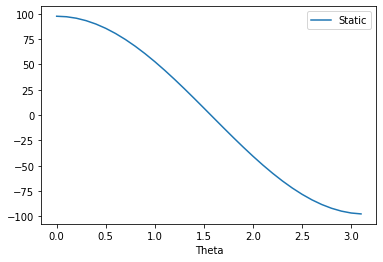

In [148]:
start = 0 * math.pi
end = (1) * math.pi
TorStatic = []
ArmLength = []
for theta in np.arange(start,end,0.1):
    TorStatic.append(static(r1,m1,r2,m2,theta))
ArmLength = np.full(len(TorStatic),1)
Data = pd.DataFrame({'Theta':np.arange(start,end,0.1),
                     'Static':TorStatic,
                    'ArmLength':ArmLength}, columns = ['Theta','Static','ArmLength'])

Data.plot(x='Theta',y='Static')


In [137]:
static(r1,m1,r2,m2,start)

0.0

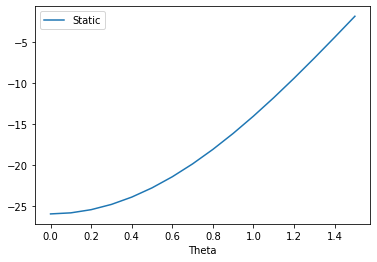

In [80]:
TorStatic = []
ArmLength = []

for theta in np.arange(start,end,0.1):
    TorStatic.append(static(r1,m1,r2,m2,theta))
ArmLength = np.full(len(TorStatic),1)
Data = pd.DataFrame({'Theta':np.arange(start,end,0.1),
                     'Static':TorStatic,
                    'ArmLength':ArmLength}, columns = ['Theta','Static','ArmLength'])

Data.plot(x='Theta',y='Static')

In [16]:
dataTable = pd.read_csv('FRC_20230203_234218_List.csv')
dataTable.head()

,Timestamp,Name,Value
0,0.666789,NT:/Preferences/ArmPosition,75
1,0.666789,NT:/Preferences/ArmP,50
2,0.779953,NT:/LiveWindow/.status/LW Enabled,false
3,0.983692,NT:/FMSInfo/.type,FMSInfo
4,0.983985,NT:/FMSInfo/GameSpecificMessage,NaN


In [34]:
dataTable['Time'] = dataTable['Timestamp'].round(2)
COI=['NT:/SmartDashboard/Arm Angle',
    'NT:/SmartDashboard/Arm Rate',
    'NT:/SmartDashboard/Est. ArmVolts']

AngleData = dataTable.loc[dataTable['Name']==COI[0],['Time','Value']]
RateData = dataTable.loc[dataTable['Name']==COI[1],['Time','Value']]
VoltData = dataTable.loc[dataTable['Name']==COI[2],['Time','Value']]

In [55]:

DataOI = VoltData.merge(AngleData.merge(RateData, on='Time', suffixes= ['_Angle','_Rate']), how='outer', on='Time')

DataOI.loc[:,'Value_Angle'] = DataOI['Value_Angle'].fillna(method='ffill').astype(float)
DataOI.loc[:,'Value_Rate'] = DataOI['Value_Rate'].fillna(method='ffill').astype(float)
DataOI.loc[:,'Value'] = DataOI['Value'].fillna(method='ffill').astype(float)
DataOI = DataOI.sort_values('Time')

<AxesSubplot:xlabel='Time'>

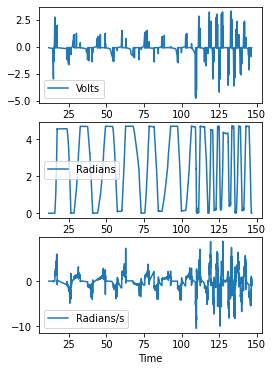

In [59]:
fig, axs = plt.subplots(3, figsize=(4,6))
DataOI.plot(x='Time',y='Value', ax= axs[0], label = 'Volts')
DataOI.plot(x= 'Time',y= 'Value_Angle',ax=axs[1], label = 'Radians')
DataOI.plot(x='Time', y='Value_Rate', ax = axs[2], label = 'Radians/s')

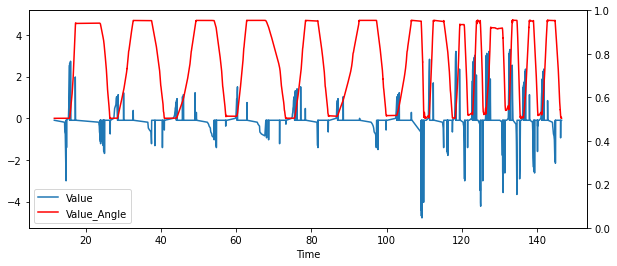

In [118]:
ax = DataOI.plot(x='Time',y='Value', figsize=(10,4))
ax2 = ax.twinx()
DataOI.plot(x='Time',y='Value_Angle', ax=ax, color = 'r')
plt.show()

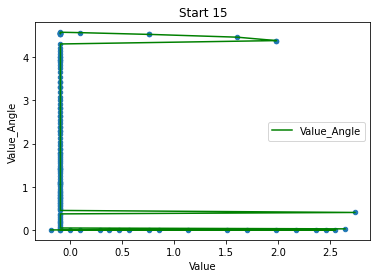

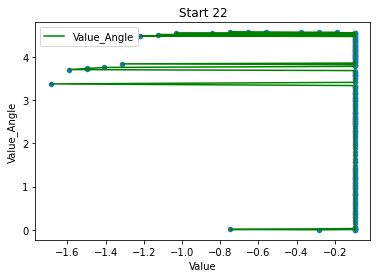

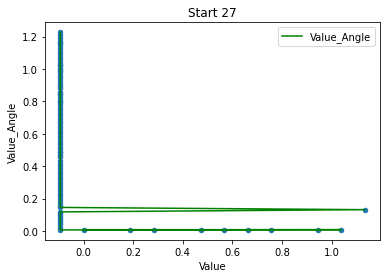

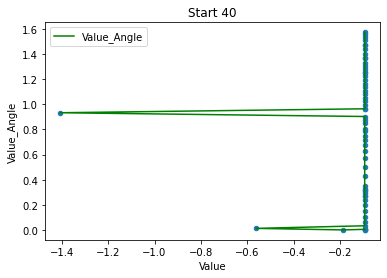

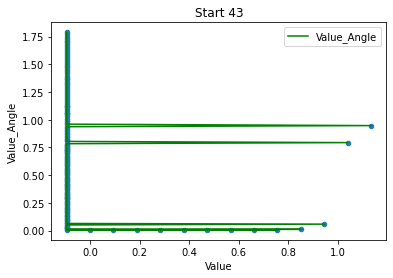

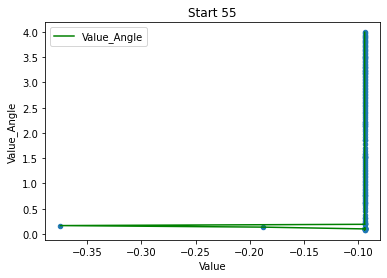

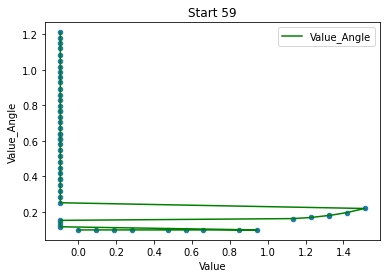

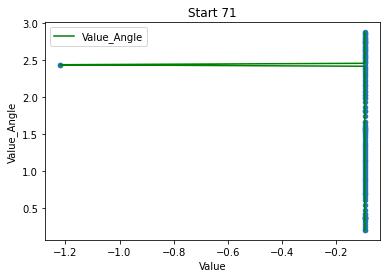

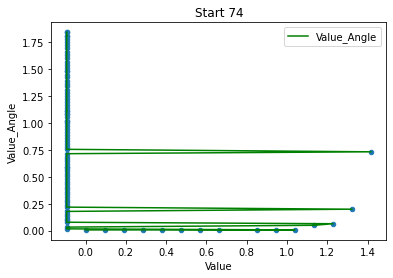

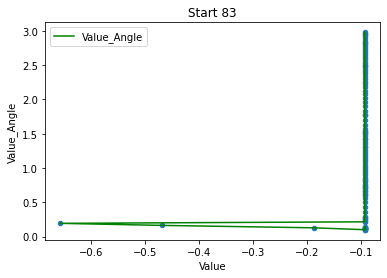

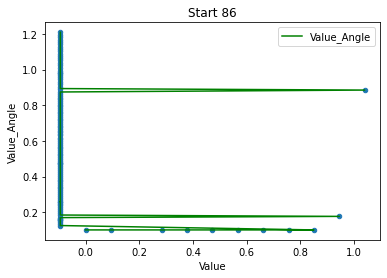

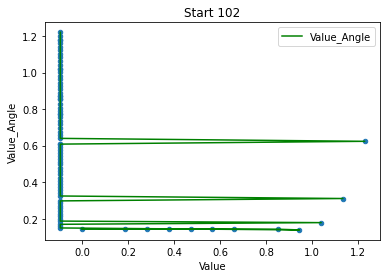

In [116]:
TimesOI = [[15,18],[22,27],[27,30],[40,43],[43,47],[55,58],[59,61],
           [71,73],[74,77],[83,85],[86,89],[102,104]]
QuasiData = pd.DataFrame()
for times in TimesOI:
    tmpData = DataOI.loc[DataOI['Time'].between(times[0],times[1]),]
    QuasiData = QuasiData.append(tmpData)
    ax = tmpData.plot.scatter(x='Value', y='Value_Angle', title=('Start ' + str(times[0])))
    tmpData.plot(x='Value', y='Value_Angle', title=('Start ' + str(times[0])), color = 'g', ax = ax)
    
    plt.show()

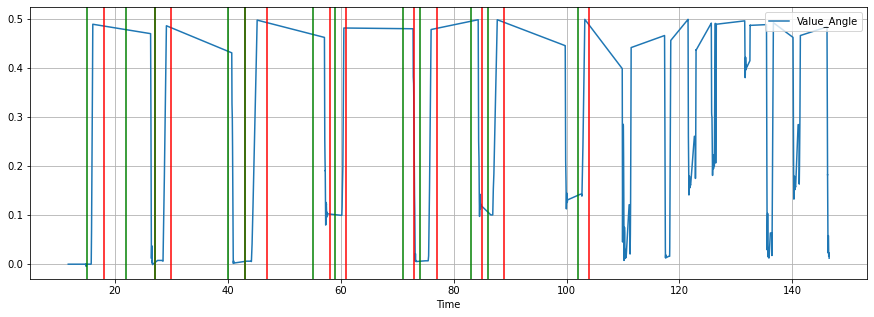

In [114]:
ax = DataOI.loc[(DataOI['Value_Angle'] < 0.5) & (DataOI['Time']>0) & (DataOI['Time']<150) ,
               ].plot(x='Time',y='Value_Angle', figsize=(15,5))
for times in TimesOI:
    ax.axvline(times[0], color = 'green')
    ax.axvline(times[1], color = 'red')
    
ax.grid(which='both')

<AxesSubplot:xlabel='Value', ylabel='Value_Angle'>

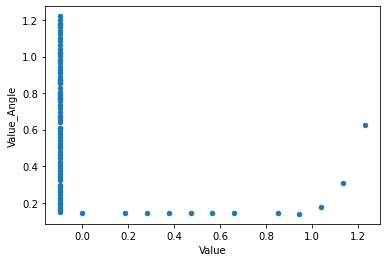

In [100]:
tmpData.plot.scatter(x='Value', y='Value_Angle')

In [89]:
StaticData = QuasiData.loc[QuasiData['Value_Angle'] < 1,]

Text(0, 0.5, 'Angular Rotation')

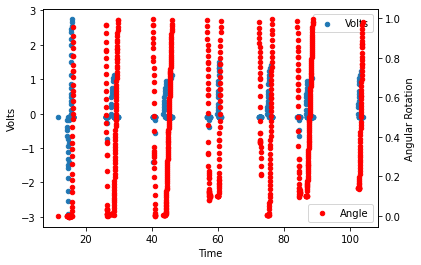

In [99]:
ax = StaticData.plot.scatter(x='Time',y='Value', label = 'Volts')
ax2 = ax.twinx()
StaticData.plot.scatter(x='Time',y='Value_Angle', ax=ax2, color = 'red', label = 'Angle')
ax.set_ylabel('Volts')
ax2.set_ylabel('Angular Rotation')

In [141]:
dataTable = pd.read_csv('FRC_20230204_204702.csv')
dataTable['Time'] = dataTable['Timestamp'].round(2)
COI=['NT:/SmartDashboard/Arm Angle',
    'NT:/SmartDashboard/Arm Rate',
    'NT:/SmartDashboard/Arm Volts']

AngleData = dataTable.loc[dataTable['Name']==COI[0],['Time','Value']]
RateData = dataTable.loc[dataTable['Name']==COI[1],['Time','Value']]
VoltData = dataTable.loc[dataTable['Name']==COI[2],['Time','Value']]
DataOI = VoltData.merge(AngleData.merge(RateData, on='Time', suffixes= ['_Angle','_Rate']), how='outer', on='Time')

DataOI.loc[:,'Value_Angle'] = DataOI['Value_Angle'].fillna(method='ffill').astype(float)
#DataOI.loc[:,'Value_Angle'] = DataOI["Value_Angle"] + 2.5
DataOI.loc[:,'Value_Rate'] = DataOI['Value_Rate'].fillna(method='ffill').astype(float)
DataOI.loc[:,'Value'] = DataOI['Value'].fillna(method='ffill').astype(float)
DataOI = DataOI.sort_values('Time')

Ks = 0.752


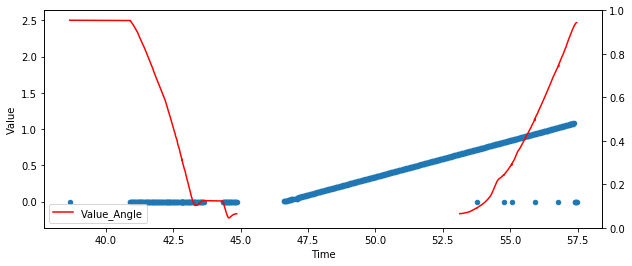

In [103]:
ax = DataOI.plot.scatter(x='Time',y='Value', figsize=(10,4))
ax2 = ax.twinx()
DataOI.plot(x='Time',y='Value_Angle', ax=ax, color = 'r')
AngleMoveTime = DataOI.loc[(DataOI['Time']>50) & (DataOI['Value_Angle'] > 0),'Time'].min()
Ks = DataOI.loc[DataOI['Time']==AngleMoveTime,'Value'].iloc[0]
print("Ks = {:.3f}".format(Ks))
plt.show()



Analysis of these plots demonstrates that the voltage required to move the apparatus at all is 0.752 volts. This will be the K$_s$ values in our feedforward calculations.
# Calculation of K$_g$ and K$_v$ from QuasiStatic Analysis of unloaded arm.

These data were collected from a range of -0.77 radians (-44°) to 4.18 radians (240°), with 0 defined as the arm in a horizontal position. From the minimal value a 0.9 V step was applied to provide a constant drive to the motor.

In [104]:
dataTable = pd.read_csv('FRC_20230204_205449.csv')
dataTable['Time'] = dataTable['Timestamp'].round(2)
COI=['NT:/SmartDashboard/Arm Angle',
    'NT:/SmartDashboard/Arm Rate',
    'NT:/SmartDashboard/Arm Volts']

AngleData = dataTable.loc[dataTable['Name']==COI[0],['Time','Value']]
RateData = dataTable.loc[dataTable['Name']==COI[1],['Time','Value']]
VoltData = dataTable.loc[dataTable['Name']==COI[2],['Time','Value']]
DataOI = VoltData.merge(AngleData.merge(RateData, on='Time', suffixes= ['_Angle','_Rate']), how='outer', on='Time')

DataOI.loc[:,'Value_Angle'] = DataOI['Value_Angle'].fillna(method='ffill').astype(float)
#DataOI.loc[:,'Value_Angle'] = DataOI["Value_Angle"] + 2.5
DataOI.loc[:,'Value_Rate'] = DataOI['Value_Rate'].fillna(method='ffill').astype(float)
DataOI.loc[:,'Value'] = DataOI['Value'].fillna(method='ffill').astype(float)
DataOI = DataOI.loc[DataOI['Time']> 51,].sort_values('Time')
DataOI = DataOI.iloc[1:,:]

<AxesSubplot:xlabel='Time'>

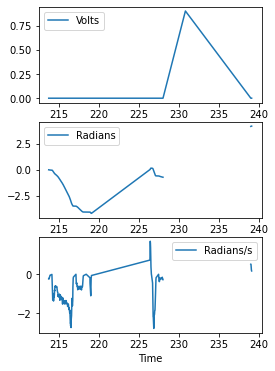

In [142]:
fig, axs = plt.subplots(3, figsize=(4,6))
DataOI.plot(x='Time',y='Value', ax= axs[0], label = 'Volts')
DataOI.plot(x= 'Time',y= 'Value_Angle',ax=axs[1], label = 'Radians')
DataOI.plot(x='Time', y='Value_Rate', ax = axs[2], label = 'Radians/s')

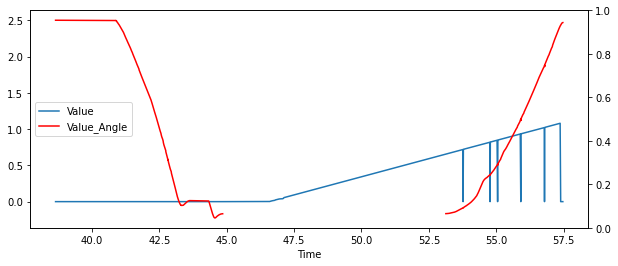

In [138]:
DataOI['cos_Theta'] = np.cos(DataOI['Value_Angle'])
ax = DataOI.plot(x='cos_Theta', y= 'Value_Rate')
DataOI.plot.scatter(x='cos_Theta', y= 'Value_Rate', ax = ax)
ax.axvline(0, color = 'red')
plt.show()

The linearity of this requires a bit of imagination. This protocol starts with a cos($\theta$) of about 0.75, which increase to 1 then begins moving back towards a cos($\theta$) of 0, when the arm is vertical. Shortly after this vertical position, there is a large deviation from the expected linear increase. This is likely to to the mechanism slipping allowing the arm to skip forward. Notabley, this is followed by a period of slower rotational movement as the mechanism catches again. Using all of the data we get the following:

The slope of the line of best fit is -0.13 with an intercept of 0.62.


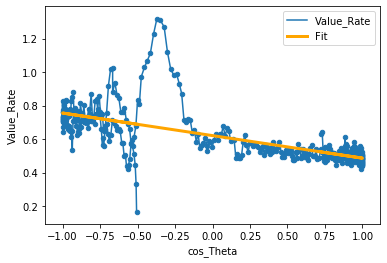

In [110]:
import scipy.stats
lm = scipy.stats.linregress(DataOI['cos_Theta'].to_numpy(), DataOI['Value_Rate'].to_numpy())
slope = lm.slope
intercept = lm.intercept
print('The slope of the line of best fit is {:.2f} with an intercept of {:.2f}.'.format(slope,intercept))
DataOI['Fit'] = slope * DataOI['cos_Theta'] + intercept

DataOI['cos_Theta'] = np.cos(DataOI['Value_Angle'])
ax = DataOI.plot(x='cos_Theta', y= 'Value_Rate')
DataOI.plot.scatter(x='cos_Theta', y= 'Value_Rate', ax = ax)
DataOI.plot(x='cos_Theta', y= 'Fit', ax = ax, color = 'orange', lw=3)
plt.show()

Based on our prior derivation the slope of this line is :<br />
slope = $\frac{-K_g}{K_v}$ <br />
and the intercept is: <br />
intercept = $\frac{V - K_s}{K_v}$ <br />
Given that V = 0.9 V, K$_s$ = 0.752; K$_v$ = $\frac{V - K_s}{intercept} = \frac{0.9 V - 0.752 V}{0.62 rad/s} = 0.239 V•sec/rad$ <br />
We can then use this calculated value of K$_v$ to determine K$_g$, by K$_g$ = -slope * K$_v$ = 0.13 rad/s * 0.239 V•sec/rad = 0.031 V. <br />
## Weighted arm calculations
The imbalance between the frictional component K$_v$ and the gravitational component K$_g$ likely results from the very light nature of the miniArm construct. To explore the consequences of adding weight to the end of the arm, our mini arm was fit with bearings secured to the end of the arm. Similar experimental paradigms were used to characterize this loaded model. We begin by calculating K$_s$.


In [143]:
dataTable = pd.read_csv('FRC_20230204_205449.csv')
dataTable['Time'] = dataTable['Timestamp'].round(2)
COI=['NT:/SmartDashboard/Arm Angle',
    'NT:/SmartDashboard/Arm Rate',
    'NT:/SmartDashboard/Arm Volts']

AngleData = dataTable.loc[dataTable['Name']==COI[0],['Time','Value']]
RateData = dataTable.loc[dataTable['Name']==COI[1],['Time','Value']]
VoltData = dataTable.loc[dataTable['Name']==COI[2],['Time','Value']]
DataOI = VoltData.merge(AngleData.merge(RateData, on='Time', suffixes= ['_Angle','_Rate']), how='outer', on='Time')

DataOI.loc[:,'Value_Angle'] = DataOI['Value_Angle'].fillna(method='ffill').astype(float)
DataOI.loc[:,'Value_Angle'] = DataOI["Value_Angle"] + 2.5
DataOI.loc[:,'Value_Rate'] = DataOI['Value_Rate'].fillna(method='ffill').astype(float)
DataOI.loc[:,'Value'] = DataOI['Value'].fillna(method='ffill').astype(float)
DataOI_static1 = DataOI.loc[DataOI['Time'].between(45,55),].sort_values('Time')
DataOI_static1 = DataOI_static1.iloc[1:,:]
DataOI_static2 = DataOI.loc[DataOI['Time'].between(80,85),].sort_values('Time')
DataOI_static2 = DataOI_static2.iloc[1:,:]


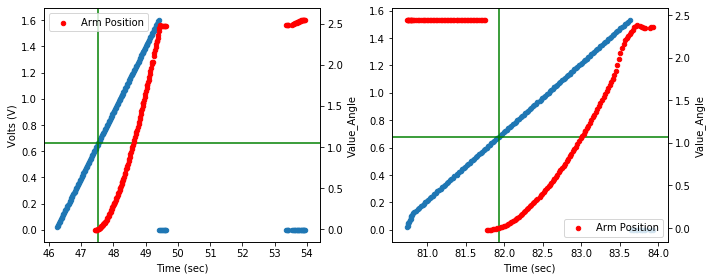

Average weighted Ks = 0.670V


In [154]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
DataOI_static1.plot.scatter(x='Time',y='Value', ax = axs[0])
ax2 = axs[0].twinx()
DataOI_static1.plot.scatter(x='Time',y='Value_Angle', ax=ax2, color = 'r', label = "Arm Position")
AngleMoveTime = DataOI_static1.loc[(DataOI_static1['Time']>47) & (DataOI_static1['Value_Angle'] > 0),'Time'].min()
Ks = DataOI_static1.loc[DataOI_static1['Time']==AngleMoveTime,'Value'].iloc[0]
axs[0].axvline(AngleMoveTime, color='green')
axs[0].axhline(Ks, color = 'green')
ax = DataOI_static2.plot.scatter(x='Time',y='Value', ax=axs[1])
ax2 = axs[1].twinx()
DataOI_static2.plot.scatter(x='Time',y='Value_Angle', ax=ax2, color = 'r', label = "Arm Position")
AngleMoveTime = DataOI_static2.loc[(DataOI_static2['Time']>81.76) &\
                                   (DataOI_static2['Value_Angle'] > 0) &\
                                   (DataOI_static2['Value_Angle'] <1 ),'Time'].min()
axs[1].axvline(AngleMoveTime, color='g')
Ks_2 = DataOI_static2.loc[DataOI_static2['Time']==AngleMoveTime,'Value'].iloc[0]
axs[1].axhline(Ks_2, color='g')

axs[0].set_ylabel("Volts (V)")
axs[1].set_ylabel("")
axs[0].set_xlabel("Time (sec)")
axs[1].set_xlabel("Time (sec)")
plt.tight_layout()
plt.show()

print("Average weighted Ks = {:.3f}V".format((Ks+Ks_2)/2))




These plots demonstrate that the K$_v$ for the loaded arm is sligtly lower than that for the unwieghted arm. This likely results from changes in the contribution of gravity. When making these measurements we placed the arm in a vertical position, this was done to limit the effects of graviety on the voltage required to begin moving the mechanism. However, it is a little difficult to completely isolate the effects of gravity if the arm was slightly off of vertical, the mass at the end of the arm will provide some torque which can reduce the voltage required to begin rotational movement. Overall the effect of loading the arm is relatively minor with a variation of only $\approx$100mV.  <br />
## Quasistatic measurements
As previously performed, the voltage was stepped to 0.9 V and the movement of the arm was measured. This was repeated several times and the resulting data combined for the following analysis.

In [218]:
qTimes = [[104,110],[129,135],[258,261],[278,283]]
qData = pd.DataFrame()
for idx, times in enumerate(qTimes):
    tmpData = DataOI.loc[DataOI['Time'].between(times[0],times[1]),]
    tmpData.loc[:,'RunID'] = 'Run_'+str(idx)
    qData = qData.append(tmpData)

/Users/town0045/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/town0045/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


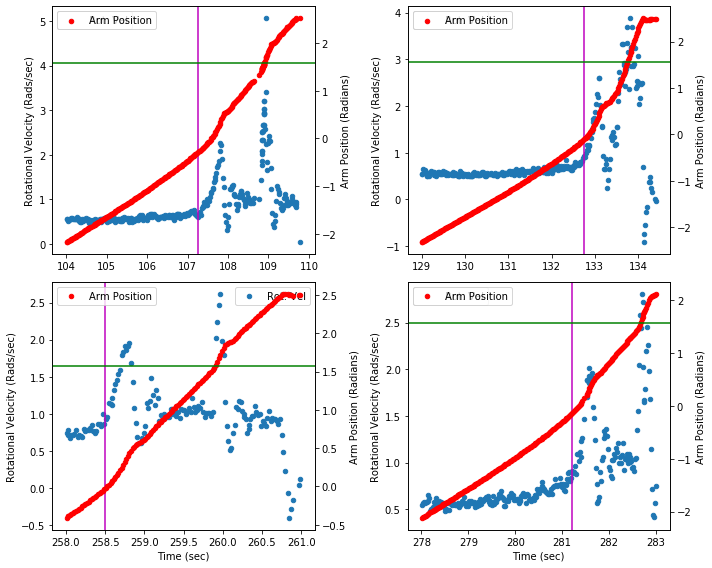

In [219]:
fig, axs = plt.subplots(2,2, figsize = (10,8))
plotmap = {0:[0,0],1:[0,1],2:[1,0],3:[1,1]}
cutoffs = {0:107.25, 1:132.75, 2:258.5, 3:281.2}
q_Data = pd.DataFrame()
for i in range(0,4):
    plotData = qData.loc[qData['RunID'] == 'Run_' + str(i),]
    plotLoc = plotmap[i]
    plotData.plot.scatter(x='Time', y = 'Value_Rate', ax= axs[plotLoc[0],plotLoc[1]],label = "Rot. Vel")
    ax2 = axs[plotLoc[0],plotLoc[1]].twinx()
    plotData.plot.scatter(x='Time', y= 'Value_Angle', ax= ax2, c='r', label = 'Arm Position')
    ax2.set_ylabel("Arm Position (Radians)")
    axs[plotLoc[0],plotLoc[1]].set_ylabel("Rotational Velocity (Rads/sec)")
    axs[plotLoc[0],plotLoc[1]].set_xlabel("Time (sec)")
    axs[plotLoc[0],plotLoc[1]].axvline(cutoffs[i], color = 'm')
    ax2.axhline(math.pi/2, c= 'green', label = "$\pi$/2")
    tmpData = plotData.loc[plotData['Time']< cutoffs[i],]
    q_Data = q_Data.append(tmpData)

axs[0,0].tick_params(axis='both', which='both',  labelbottom=True)
axs[0,1].tick_params(axis='both', which='both',  labelbottom=True)
plt.tight_layout()
plt.show()

These plots demonstrate that our mechanism was quite noisy as the arm approached a vertical orientation and during the descent. This was accompanyied/caused by slipping of the belt. To account for this we will perform that analysis on the portion of the plot where the mechanism was at work. This might create a bias, as we are only looking at values during the up swing of the arm. We will need to make sure that the mechanism does not slip when we characterize the real mechanism. Using this truncated dataset we will perform the analysis to determine the nature of the K$_v$ and K$_g$ in this system.

The slope of the line of best fit is 0.12 with an intercept of 0.57.
The slope of the line of best fit is -0.04 with an intercept of 0.53.


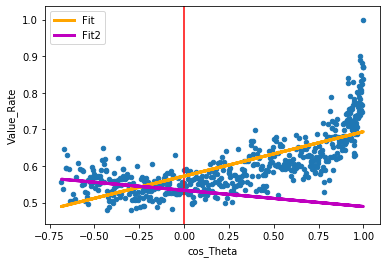

In [224]:
q_Data['cos_Theta'] = np.cos(q_Data['Value_Angle'])
ax = q_Data.plot.scatter(x='cos_Theta', y= 'Value_Rate')
#qData.plot.scatter(x='cos_Theta', y= 'Value_Rate', ax = ax)
ax.axvline(0, color = 'red')

lm = scipy.stats.linregress(q_Data['cos_Theta'].to_numpy(), q_Data['Value_Rate'].to_numpy())
slope = lm.slope
intercept = lm.intercept
print('The slope of the line of best fit is {:.2f} with an intercept of {:.2f}.'.format(slope,intercept))
q_Data['Fit'] = slope * q_Data['cos_Theta'] + intercept
q_Data.plot(x='cos_Theta', y= 'Fit', ax = ax, color = 'orange', lw=3)

q2_Data = q_Data.loc[q_Data['cos_Theta']<0,]
lm2 = scipy.stats.linregress(q2_Data['cos_Theta'].to_numpy(), q2_Data['Value_Rate'].to_numpy())
slope2 = lm2.slope
intercept2 = lm2.intercept
print('The slope of the best fit is {:.2f} with an intercept of {:.2f}.'.format(slope2,intercept2))
q_Data['Fit2'] = slope2 * q_Data['cos_Theta'] + intercept2
q_Data.plot(x='cos_Theta', y= 'Fit2', ax = ax, color = 'm', lw=3)

plt.show()



## Calculations
K$_s$ for this sytem was determined to be 0.670V. Thus, K$_v$ = $\frac{V - K_s}{intercept} = \frac{0.9 V - 0.670 V}{0.57 rad/s} = 0.404 V•sec/rad$ <br />
We can then use this calculated value of K$_v$ to determine K$_g$, by K$_g$ = -slope * K$_v$ = -0.12 rad/s * 0.404 V•sec/rad = -0.297 V. <br />
The negative value for a K$_g$ makes sense for a mechanism that was slipping on the downward slope. This is evidentd in the high rotational velocities observed when the arm was near horizontal on the downward slope. If the analysis is resticted to negative cos($\theta$) we get a slope of -0.04 and an intercept of 0.53. These values result in a K$_v$ of 0.434 V•sec/rad and a K$_g$ of 0.017 V. 
# Conclusions
The K$_s$ values for our arm with and without weight are reasonably close to one another (0.752 V without weight and 0.670 V with weight). As discussed above, we think that the K$_v$ value in the weighted model is affected by the mass of the arm providing additional torque to the arm to start the rotational process. Despite this effect, the valuese are relatively similar suggesting that most of the static voltage is secondary to resistance within the gearbox and motor. The values of K$_v$ were pretty different with a value of 0.254 V•rad/s in the unweighted model and 0.404 V•rad/s in the weighted arm. This $\approx$60% increase in weight is likely do to the increased friction on the bearings. <br />
The measures of the K$_g$ are the most fraught with errors resulting from insufficencies of our general system. Despite removing many of the confounding measurements, we still get a K$_g$ value that is lower in the weighted arm vs. the unweighted arm. This doesn't make a lot of sense, as the K$_g$ values include a factor that includes the overall mass of the arm and should be greater when the mass of the arm is increased. This descripency likely results from the deficiencies in the mechanism used. There were clearly evident mechanical issues, belt skipping especially in the weighted arm. Another possibility is that most of these measurements were made late in the day and the battery voltage might have not been ideal, although the loads on the battery were relatively low.<br />
A significant omission of the current data set is that we have no measure of K$_a$. This can be measured using a dynamic voltage protocol where the arm voltage is rapidly stepped to a high voltage ($\approx$ 6-7V). This causes a dramatic acceleration, which can be measured. Then using a similar approach of linear regression we can estimate K$_a$. This approach requires a robust mechanaism because of the forces applied during the rapid acceleration, so this measure may need to wait until we have a more finalized mechanism. In summary, this exercise has provided us with important tools that will accellerate our characterization of the final robot arm when it is complete.
